In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading the data

def load_data():
    from sklearn.model_selection import train_test_split

    data = np.genfromtxt('time_temp_2016.tsv', delimiter='\t')
    
    x = data[:, 0]
    x = x.reshape((x.shape[0], 1))
    y = data[:, 1]
    
    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(x, y, test_size=0.33, random_state=42)
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x.T, test_set_x.T, train_set_y, test_set_y, x.T

train_set_x, test_set_x, train_set_y, test_set_y, full_feature_set_for_plot = load_data()

In [3]:
print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)

(1, 245) (1, 245) (1, 121) (1, 121)


In [4]:
m_train = train_set_x.shape[1]
m_test = test_set_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

print ("\ntrain_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 245
Number of testing examples: m_test = 121

train_set_x shape: (1, 245)
train_set_y shape: (1, 245)
test_set_x shape: (1, 121)
test_set_y shape: (1, 121)


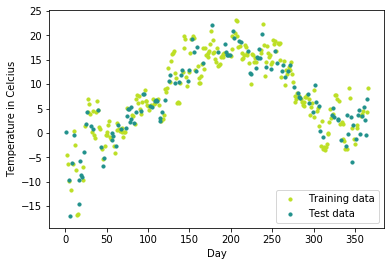

In [5]:
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * train_set_x, train_set_y, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * test_set_x, test_set_y, color=cmap(0.5), s=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

In [6]:
def polynomial_features(X, degree):
    
    from itertools import combinations_with_replacement 
    # combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC
    
    n_features, n_samples = np.shape(X)
    
    def index_combinations(): ## (1, 2) => [(1),(2),(1,1),(1,2),(2,2)]
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        ##comb = [(),((1),(2)),((1,1),(1,2),(2,2))]
        flat_combs = [item for sublist in combs for item in sublist]
        ##flat_combs = [(1),(2),(1,1),(1,2),(2,2)]
        return flat_combs
    
    combinations = index_combinations()
    
    n_output_features = len(combinations)
    
    X_new = np.empty((n_output_features, n_samples))
    
    for i, index_combs in enumerate(combinations):  
        X_new[i, :] = np.prod(X[index_combs, :], axis=0)
        ## if index_combs == (1,2,3) =>  X_new[:,i] = X[:,1] * X[:,2] * X[:,3] 
    return X_new

In [7]:
# mean_squared_error

def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred 
    
    Arguments:
    y_true -- array of true values
    y_pred -- array of predicted values
    
    Returns:
    mse -- mean squared error
    """
    mse = np.sum((y_pred - y_true) ** 2) / y_true.squeeze().shape[0]
    
    return mse

In [8]:
print ("mse = " + str(mean_squared_error(np.array([1, 2, 3, 4]), np.array([2, 3, 4, 6]))))

mse = 1.75


In [9]:
# l2_regularization

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        """ Set alpha """
        self.alpha = alpha
    
    def __call__(self, w):
        """ 
        Computes l2 regularization term
        
        Arguments:
        w -- weights

        Returns:
        term -- 1/2 * alpha * norm(w)^2
        """
        term = np.sum(w ** 2) * self.alpha / 2
        return term

    def grad(self, w):
        """ 
        Computes derivative of l2 regularization term
        
        Arguments:
        w -- weights

        Returns:
        vector -- alpha * w
        """        
        derivative = self.alpha * w
                
        return derivative

In [10]:
l2 = l2_regularization(0.5)
print ("l2 reg. term = " + str(l2(np.array([1, 2, 3, 4]))))
print ("l2 grad. = " + str(l2.grad(np.array([1, 2, 3, 4]))))

l2 reg. term = 7.5
l2 grad. = [0.5 1.  1.5 2. ]


In [11]:
# PolynomialRidgeRegression

class PolynomialRidgeRegression(object):
    """
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: int
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, print_error=False):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.print_error = print_error
    
        
    def initialize_with_zeros(self, n_features):
        """
        This function creates a vector of zeros of shape (n_features, 1)
        
        Arguments:
        n_features -- amount of features
        """        
        self.w = np.zeros((n_features, 1))
                
        
    def fit(self, X, Y):        
        # Generate polynomial features
        X = polynomial_features(X, self.degree)        

        # Insert constant ones for bias weights
        biases = np.ones((1, X.shape[1]))
        X = np.vstack((biases, X))        
        
        # Create array
        self.initialize_with_zeros(n_features=X.shape[0])        

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            # Calculate prediction
            H = np.dot(self.w.T, X)            

            # Gradient of l2 loss
            grad_w = self.regularization.grad(self.w)            

            # Update the weights
            deltas = H - Y            
            self.w = self.w - self.learning_rate * (np.dot(X, deltas.T) + grad_w)

            if self.print_error and i % 1000 == 0:
                # Calculate l2 loss
                mse = mean_squared_error(Y, H)                
                print ("MSE after iteration %i: %f" %(i, mse))
        
            
    def predict(self, X):        
        # Generate polynomial features
        X = polynomial_features(X, self.degree)
        
        # Insert constant ones for bias weights
        biases = np.ones((1, X.shape[1]))
        X = np.vstack((biases, X))
        
        # Calculate prediction
        y_pred = np.dot(self.w.T, X)        
        
        return y_pred

In [12]:
poly_degree = 15
learning_rate = 0.001
n_iterations = 10000
reg_factor = 0.1

In [13]:
model = PolynomialRidgeRegression(
    degree=poly_degree, 
    reg_factor=reg_factor,
    learning_rate=learning_rate,
    n_iterations=n_iterations,
    print_error=True
)

In [14]:
model.fit(train_set_x, train_set_y)

MSE after iteration 0: 127.482367
MSE after iteration 1000: 14.568897
MSE after iteration 2000: 12.862790
MSE after iteration 3000: 12.687616
MSE after iteration 4000: 12.652576
MSE after iteration 5000: 12.640050
MSE after iteration 6000: 12.632690
MSE after iteration 7000: 12.627097
MSE after iteration 8000: 12.622458
MSE after iteration 9000: 12.618504


In [15]:
y_predictions = model.predict(test_set_x)

In [16]:
mse = mean_squared_error(test_set_y, y_predictions)

In [17]:
print ("Mean squared error on test set: %s (given by reg. factor: %s)" % (mse, reg_factor))

Mean squared error on test set: 11.019103172630942 (given by reg. factor: 0.1)


In [18]:
print (f"Mean squared error on test set: {mse} (given by reg. factor: {reg_factor})")

Mean squared error on test set: 11.019103172630942 (given by reg. factor: 0.1)


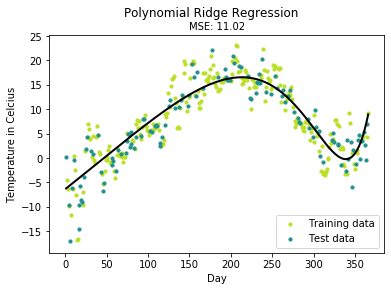

In [19]:
cmap = plt.get_cmap('viridis')

# Predict for all points in set
y_val = model.predict(full_feature_set_for_plot)

# Plot the results
m1 = plt.scatter(366 * train_set_x, train_set_y, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * test_set_x, test_set_y, color=cmap(0.5), s=10)
plt.plot(366 * full_feature_set_for_plot.T, y_val.T, color='black', linewidth=2, label="Prediction")
plt.suptitle("Polynomial Ridge Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

In [20]:
# применение модели scikit learn для датасета из time_temp_2016.tsv

train_set_x, test_set_x, train_set_y, test_set_y, full_feature_set_for_plot = load_data()
print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)

(1, 245) (1, 245) (1, 121) (1, 121)


In [21]:
# преобразуем в привычный формат - из (n_features x n_samples) в (n_samples x n_features)

train_set_x = train_set_x.T
train_set_y = train_set_y.T
test_set_x = test_set_x.T
test_set_y = test_set_y.T
print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)

(245, 1) (245, 1) (121, 1) (121, 1)


In [22]:
from sklearn.linear_model import Ridge

from sklearn.preprocessing import PolynomialFeatures

degree = 15
poly = PolynomialFeatures(degree)

train_set_x = poly.fit_transform(train_set_x)
test_set_x = poly.fit_transform(test_set_x)

model = Ridge(alpha=0.1)
model.fit(train_set_x, train_set_y)
model.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [23]:
# Return the coefficient of determination R^2 of the prediction.

model.score(train_set_x, train_set_y)

0.7932002726682527

In [24]:
# predictions on train and test sets

predictions_train = model.predict(train_set_x)
predictions_test = model.predict(test_set_x)

In [25]:
from sklearn.metrics import r2_score

r2_score(train_set_y, predictions_train)

0.7932002726682527

In [26]:
from sklearn.metrics import mean_squared_error

mean_squared_error(train_set_y, predictions_train)

12.587924173862792

In [27]:
# определение mse, используя ранее написанную пользовательскую функцию

mse = mean_squared_error(train_set_y, predictions_train)
mse

12.587924173862792

In [28]:
# mse на тестовом сете

mean_squared_error(test_set_y, predictions_test)

10.97782249410357

In [29]:
model.coef_

array([[  0.        ,  49.12005526,   8.48629654, -16.10288267,
        -24.63036797, -23.5322046 , -18.09018066, -11.39544779,
         -4.99685122,   0.43525698,   4.68958518,   7.78054463,
          9.82432017,  10.97463703,  11.39036197,  11.21999046]])

In [30]:
model.intercept_

array([-6.38388827])

In [33]:
# создание регрессионной модели с L1-регуляризацией (Lasso)

from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)
model.fit(train_set_x, train_set_y)
model.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [34]:
model.score(train_set_x, train_set_y)

0.6336096636237545

In [35]:
# создание регрессионной модели с L1 и L2 регуляризацией (ElasticNet)

from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state=0, alpha=0.03, l1_ratio=0.99)
model.fit(train_set_x, train_set_y)
model.get_params()

{'alpha': 0.03,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.99,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [36]:
model.score(train_set_x, train_set_y)

0.7660404622977228